In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import IPython.core.display as di
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
# display(HTML("<style>div.prompt {display:none}</style>"))
# display(HTML("<style>div.input {display:none}</style>"))

from ipywidgets import interact, IntSlider

import pandas as pd
import numpy as np
import datetime
import requests
import plotly.express as px
import pickle

# For html output use:
# jupyter nbconvert --execute --no-input --no-prompt --to html FPLDraft.ipynb

# league id found by going to the end point: https://draft.premierleague.com/api/bootstrap-dynamic
league_id = 43259
url_all = 'https://draft.premierleague.com/api/bootstrap-static'

max_gameweek = 4

r = requests.get(url_all)
all_data = r.json()
refresh = True

In [3]:
from IPython.display import display as disp
def freeze_header(df, num_rows=30, num_columns=10, step_rows=1,
                  step_columns=1):
    """
    Freeze the headers (column and index names) of a Pandas DataFrame. A widget
    enables to slide through the rows and columns.

    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame to display
    num_rows : int, optional
        Number of rows to display
    num_columns : int, optional
        Number of columns to display
    step_rows : int, optional
        Step in the rows
    step_columns : int, optional
        Step in the columns

    Returns
    -------
    Displays the DataFrame with the widget
    """
    @interact(last_row=IntSlider(min=min(num_rows, df.shape[0]),
                                 max=df.shape[0],
                                 step=step_rows,
                                 description='rows',
                                 readout=False,
                                 disabled=False,
                                 continuous_update=True,
                                 orientation='horizontal',
                                 slider_color='purple'),
              last_column=IntSlider(min=min(num_columns, df.shape[1]),
                                    max=df.shape[1],
                                    step=step_columns,
                                    description='columns',
                                    readout=False,
                                    disabled=False,
                                    continuous_update=True,
                                    orientation='horizontal',
                                    slider_color='purple'))
    def _freeze_header(last_row, last_column):
        disp(df.iloc[max(0, last_row-num_rows):last_row,
                        max(0, last_column-num_columns):last_column])

In [4]:
# all_data.keys()

In [5]:
team_map = {i['id']:i['short_name'] for i in all_data['teams']}
positions_map = {i['id']:i['plural_name_short'] for i in all_data['element_types']}
element_positions_map = {i['id']:positions_map[i['element_type']] for i in all_data['elements']}
player_team_map = {'{} ({})'.format(i['web_name'],team_map[i['team']]):team_map[i['team']] for i in all_data['elements']}

In [6]:
all_players_map = {i['id']:'{} ({})'.format(i['web_name'],team_map[i['team']]) for i in all_data['elements'] if i not in [496]}

all_players = list(all_players_map.keys())

In [7]:
url_league = 'https://draft.premierleague.com/api/league/{}/details'.format(league_id)
r = requests.get(url_league)
league_data = r.json()

# url_team_history = 'https://draft.premierleague.com/api/entry/{}/history'.format(user_id)

In [8]:
user_map = {
    162095:'Salmon',
    266672:'Mitesh',
    162019:'Phil',
    206655:'Marcus',
    281930:'TomH',
    165434:'Kieran',
    277102:'Dan',
    278897:'Bipin',
}

user_ids = list(user_map.keys())
user_names = [user_map[user_id] for user_id in user_ids]

In [9]:
n_gameweeks = 38
squad_size = 15
positions_playing = np.arange(12)
positions_subs = [12,13,14,15]
gameweeks = np.arange(max_gameweek)+1

if refresh:
    team_positions_history = []

    for user_id in user_ids:
        for gameweek in gameweeks:
            url_team = 'https://draft.premierleague.com/api/entry/{}/event/{}'.format(user_id, gameweek)
            r = requests.get(url_team)
            
            team_data_json = r.json()
            team_positions = pd.Series({team_data_json['picks'][i]['position']:team_data_json['picks'][i]['element'] for i in np.arange(len(team_data_json['picks']))})
            team_positions['user_id'] = user_id
            team_positions['gameweek'] = gameweek
                                
            team_positions_history = team_positions_history + [team_positions]
    team_positions_history = pd.concat(team_positions_history,axis=1).T
    team_positions_history = team_positions_history.set_index(['user_id','gameweek']).stack().reset_index().rename(columns={'level_2':'position',0:'element'})
    team_positions_history.to_pickle('team_positions_history.pkl')
else:
    team_positions_history = pickle.load(open('team_positions_history.pkl',"rb"))
    
# team_positions_history['gameweek'] = team_positions_history['gameweek'].astype('Int64')    

In [10]:
# from fpl import FPL
# import aiohttp

# session = aiohttp.ClientSession()
# fpl = FPL(session)
# all_player_info = await fpl.get_players(all_players,include_summary=True)
# await session.close()

# player_history = []
# for j,j2 in enumerate(all_players):
#     data_length = len(all_player_info[j].history)
#     for i in np.arange(data_length):
#         player_history = player_history + [pd.Series(all_player_info[j].history[i])]
# player_history = pd.concat(player_history,axis=1).T.rename(columns={'round':'gameweek'})

In [11]:
if refresh:
    player_history = []
    for player in all_players:
        url_player = 'https://draft.premierleague.com/api/element-summary/{}'.format(player)
        r = requests.get(url_player)
        
        if r.status_code == 502:
            continue
        player_data_json = r.json()['history']   
        data_length = len(player_data_json)
        for i in np.arange(data_length):
            player_history = player_history + [pd.Series(player_data_json[i])]
    player_history = pd.concat(player_history,axis=1).T.rename(columns={'event':'gameweek'})        
    player_history.to_pickle('player_history.pkl')
else:
    player_history = pickle.load(open('player_history.pkl',"rb"))
    
# player_history['gameweek'] = player_history['gameweek'].astype('Int64')    

In [12]:
# Data error correction
# player_history = player_history[player_history['element'] != 496]

In [13]:
merged_perfomance_data = pd.merge(player_history,team_positions_history,on=['element','gameweek'],how='outer')
merged_perfomance_data['player_position'] = [element_positions_map.get(element,np.nan) for element in merged_perfomance_data['element']]
merged_perfomance_data['player_name'] = [all_players_map.get(element,np.nan) for element in merged_perfomance_data['element']]
merged_perfomance_data['user_name'] = [user_map.get(element,np.nan) for element in merged_perfomance_data['user_id']]
merged_perfomance_data['player_team'] = [player_team_map.get(player_name,np.nan) for player_name in merged_perfomance_data['player_name']]
merged_perfomance_data = merged_perfomance_data.sort_values(['gameweek','fixture','element'])

In [14]:
# Find duplicates
# merged_perfomance_data[['gameweek', 'user_name', 'player_name']].groupby(['gameweek', 'player_name'])['user_name'].count().reset_index().sort_values('user_name', ascending=False).iloc[:50]
# merged_perfomance_data[(merged_perfomance_data['gameweek']==5) & (merged_perfomance_data['player_name']=='Saliba (ARS)')].T

In [15]:
merged_perfomance_data[merged_perfomance_data['minutes']==0]['total_points']=np.nan
merged_perfomance_data[merged_perfomance_data['minutes']==0]['bonus']=np.nan
# merged_perfomance_data.loc[merged_perfomance_data[pd.isnull(merged_perfomance_data['gameweek'])].index, 'gameweek'] = 0

In [16]:
# player_team_total_number = merged_perfomance_data.groupby(['gameweek','user_name'])['player_name'].count().reset_index().pivot(index='gameweek',columns='user_name',values='player_name')
# fig = px.line(player_team_total_number, title='Weekly numbers available',labels={'user_name':''})
# fig.show()

In [17]:
user_player_ownership = merged_perfomance_data[['gameweek','user_name','player_name']].drop_duplicates(keep='first').pivot(index='gameweek',columns='player_name',values='user_name')
user_player_ownership = user_player_ownership.fillna('No_owner')
user_player_trades = user_player_ownership[user_player_ownership!=user_player_ownership.shift(1)]

In [18]:
# merged_perfomance_data[['gameweek','user_name','player_name']].drop_duplicates(keep='first').sort_values(['gameweek','player_name','user_name']).pivot(index='gameweek',columns='player_name',values='user_name')

In [19]:
player_team_performance = merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing)].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points')
fig = px.line(player_team_performance, title='Weekly performance',labels={'user_name':''})
fig.show()

In [20]:
player_team_4w_performance = merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing)].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').rolling(window=4,min_periods=1).mean()
fig = px.line(player_team_4w_performance, title='Rolling 4-week performance',labels={'user_name':''})
fig.show()

In [21]:
player_points = player_team_performance.mean(0).to_frame()
player_points_std = player_team_performance.std(0).to_frame()

player_points = pd.merge(player_points,
                         player_points_std,
                         right_index=True,
                         left_index=True).reset_index()

player_points.columns = ['user_name', 'average', 'err']

fig = px.scatter(player_points, 
                 x='user_name', 
                 y='average', 
                 error_y="err", 
                 title='Average performance and error')
fig.update_traces(marker_size=10)
fig.show()

In [22]:
fig = px.line(player_team_performance.cumsum(), title='Total points',labels={'user_name':''})
fig.show()

In [23]:
# player_team_performance.subtract(player_team_performance.mean(1),axis=0).cumsum().plot(backend='plotly')
# player_team_performance.subtract(player_team_performance['Salmon'],axis=0).cumsum().plot(backend='plotly',title='Salmon relative total')

fig = px.line(player_team_performance.subtract(player_team_performance['Phil'],axis=0).cumsum(), title='Phil relative total',labels={'user_name':''})
fig.show()

In [24]:
# player_team_performance.boxplot()
# df = px.data.tips()
fig = px.strip(player_team_performance)
fig.show()

### Performance rank

In [25]:
player_team_performance.rank(1,ascending=False).astype(int).T.style.background_gradient(cmap='RdBu').set_properties(**{'width':'2em','text-align': 'center'})

### Position rank

In [26]:
player_team_performance.cumsum().rank(1,ascending=False).astype(int).T.style.background_gradient(cmap='RdBu').set_properties(**{'width':'2em','text-align': 'center'})

In [27]:
# merged_perfomance_data.groupby('user_name')['element'].nunique().sort_values(ascending=False).plot(backend='plotly',kind='bar')
fig = px.bar(merged_perfomance_data.groupby('user_name')['element'].nunique().sort_values(ascending=False),title='Most players used', labels={'value':'Number of unique players','user_name':''})
fig.layout.update(showlegend=False)
fig.show()

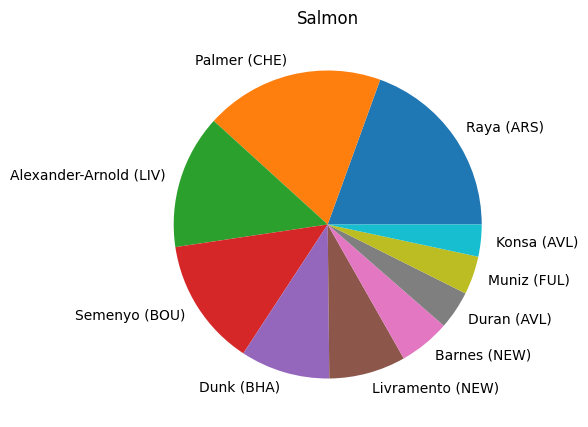

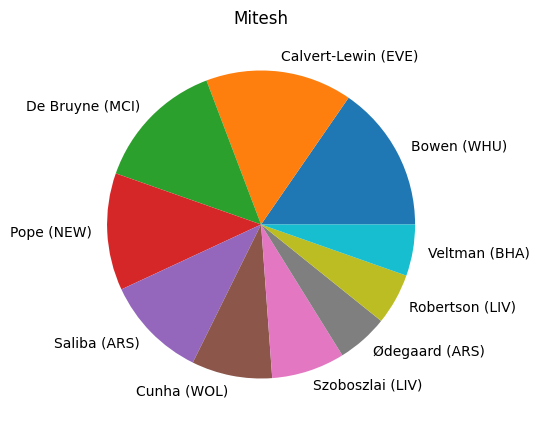

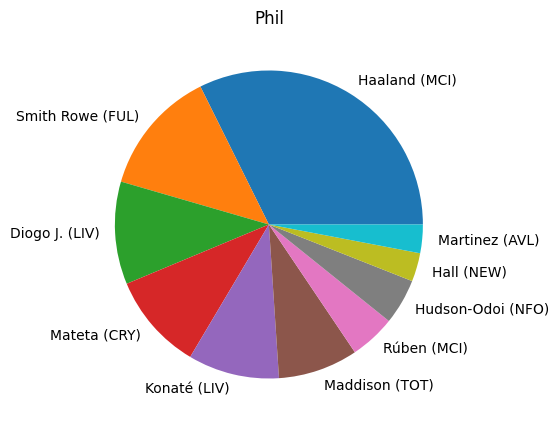

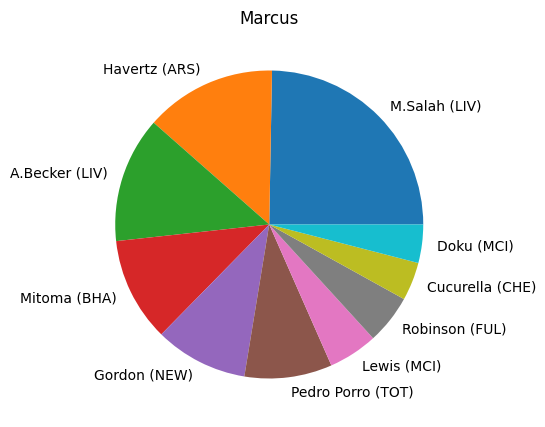

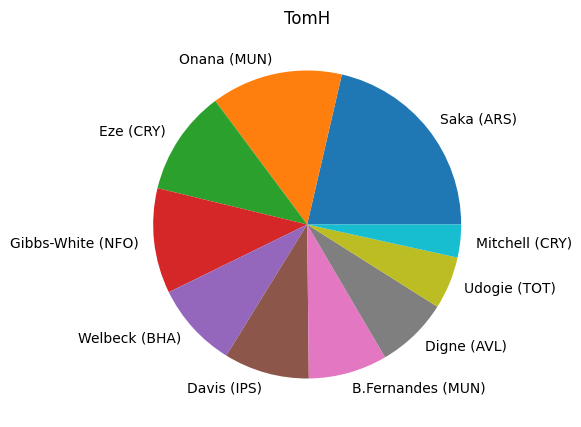

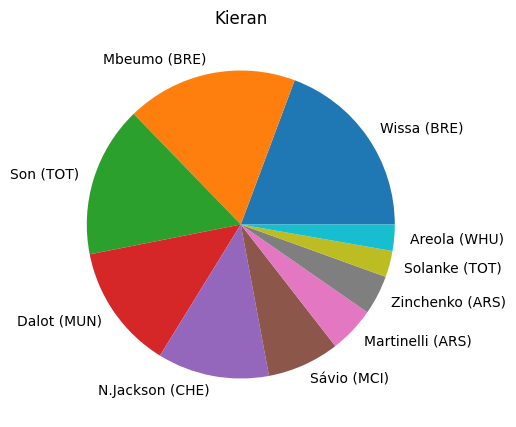

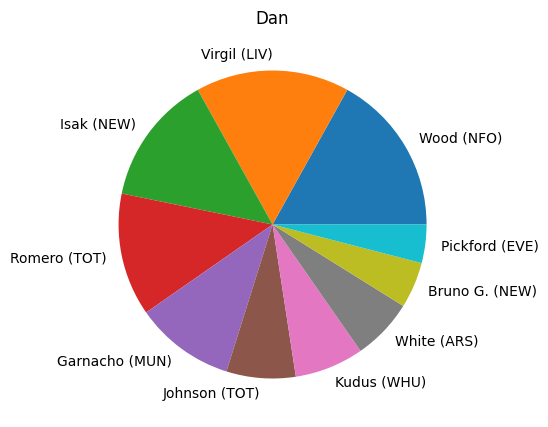

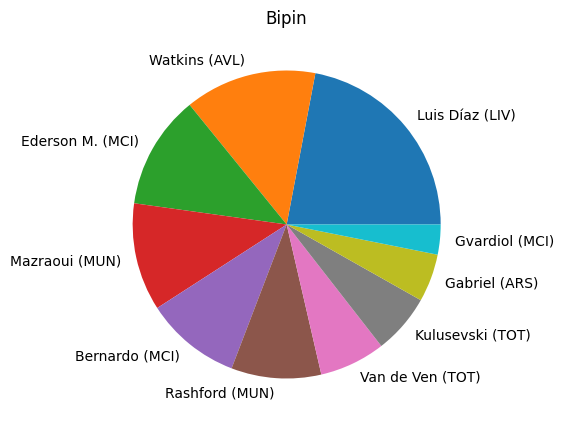

In [28]:
user_player_performances = merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing)].groupby(['user_name','player_name'])['total_points'].sum().reset_index()
# user_player_performances = (merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing)].groupby(['user_name','player_name'])['total_points'].sum()/merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing)].groupby(['user_name','player_name'])['total_points'].count()).reset_index()

for user_name in user_names:  
    user_player_performances[user_player_performances['user_name']==user_name].drop(columns='user_name').set_index('player_name').sort_values('total_points',ascending=False).iloc[:10].plot.pie(y='total_points',figsize=(5,5),title=user_name,legend=False,ylabel='');

### Best players for users (> 3 games played)

In [30]:
user_player_performance_per_game = (merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing)].groupby(['user_name','player_name'])['total_points'].sum()/merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing)].groupby(['user_name','player_name'])['total_points'].count().replace(0, np.nan))[merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing)].groupby(['user_name','player_name'])['total_points'].count()>3].reset_index()
user_player_performance_per_game.sort_values('total_points',ascending=False)[:10].reset_index(drop=True).style.set_properties(**{'text-align': 'left'}).hide_index()

AttributeError: 'Styler' object has no attribute 'hide_index'

### Worst players for users (> 3 games played)

In [31]:
user_player_performance_per_game.sort_values('total_points',ascending=True)[:10].style.set_properties(**{'text-align': 'left'}).hide_index()

AttributeError: 'Styler' object has no attribute 'hide_index'

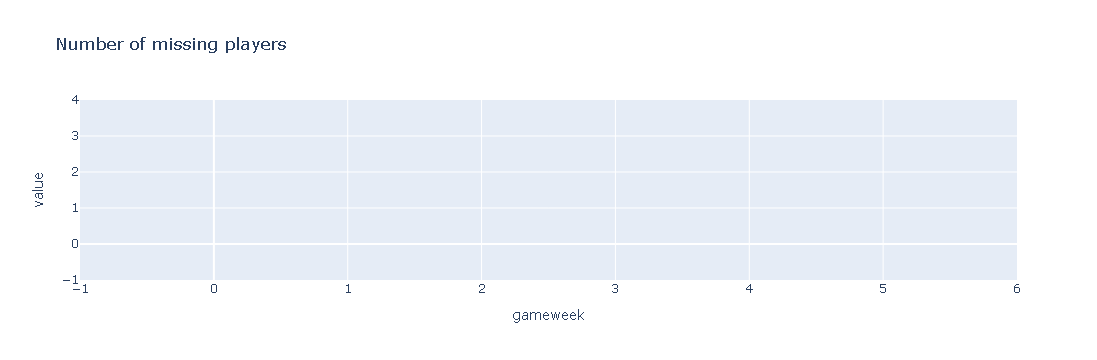

In [32]:
player_team_zero_mins = merged_perfomance_data[merged_perfomance_data['position'].isin(positions_playing) & (merged_perfomance_data['minutes']==0)].groupby(['gameweek','user_name'])['player_name'].count().reset_index().pivot(index='gameweek',columns='user_name',values='player_name').replace(np.nan,0)
fig = px.line(player_team_zero_mins, title='Number of missing players',labels={'user_name':''})
fig.show()

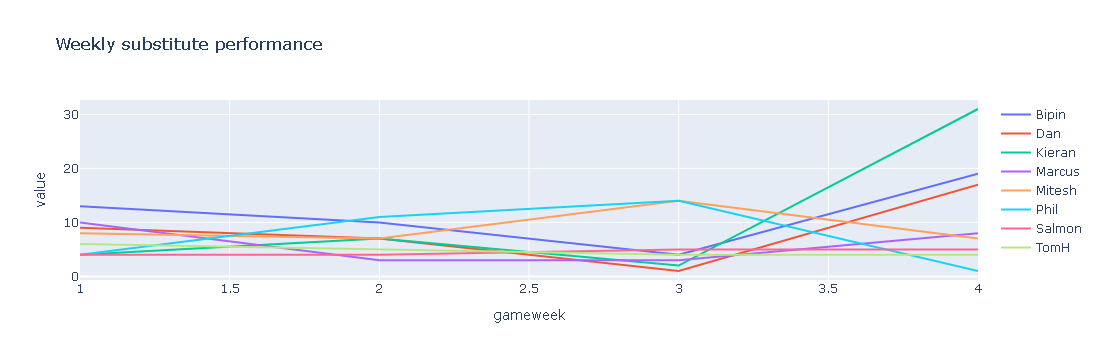

In [33]:
player_team_subs_performance = merged_perfomance_data[merged_perfomance_data['position'].isin(positions_subs)].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').replace(np.nan,0)
fig = px.line(player_team_subs_performance, title='Weekly substitute performance',labels={'user_name':''})
fig.show()

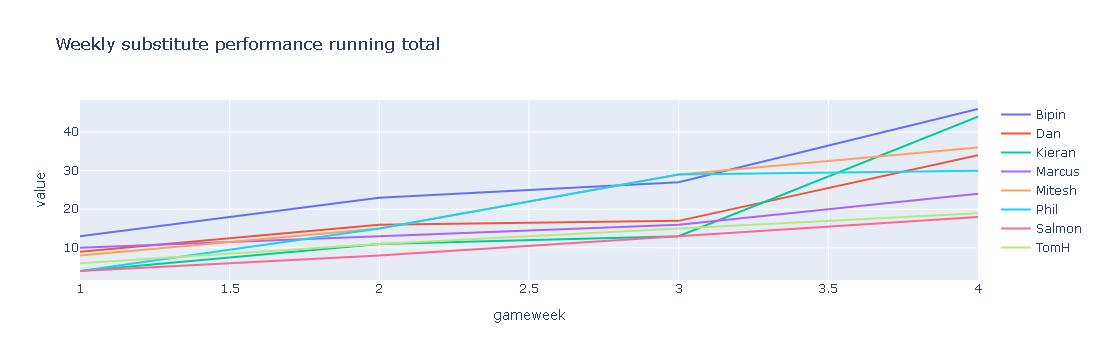

In [34]:
player_team_subs_performance = merged_perfomance_data[merged_perfomance_data['position'].isin(positions_subs)].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').replace(np.nan,0)
fig = px.line(player_team_subs_performance.cumsum(), title='Weekly substitute performance running total',labels={'user_name':''})
fig.show()

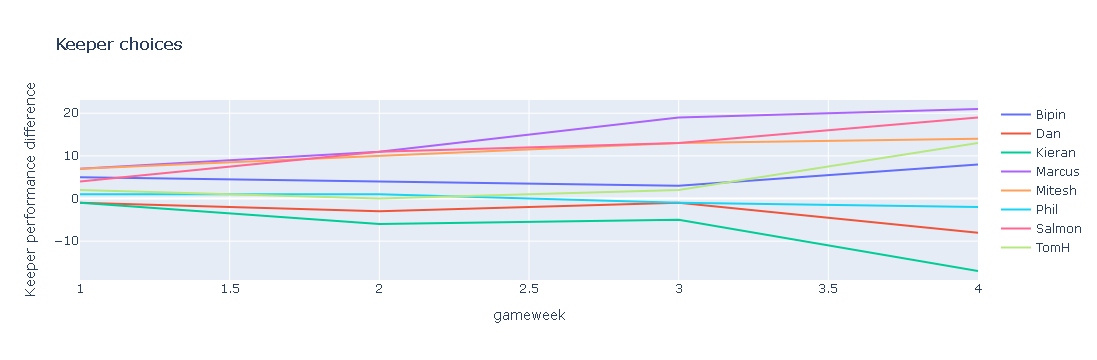

In [35]:
player_team_keeper_performance_difference = merged_perfomance_data[merged_perfomance_data['position']==1].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').replace(np.nan,0) - merged_perfomance_data[merged_perfomance_data['position']==12].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').replace(np.nan,0)
fig = px.line(player_team_keeper_performance_difference.cumsum(), title='Keeper choices',labels={'user_name':'','value':'Keeper performance difference'})
fig.show()

### Goalkeeper performance

In [36]:
player_team_keeper_performance = merged_perfomance_data[merged_perfomance_data['position']==1].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').replace(np.nan,0)
player_team_keeper_performance.rank(1,ascending=False).astype(int).T.style.background_gradient(cmap='RdBu').set_properties(**{'width':'2em','text-align': 'center'})
# fig = px.line(player_team_keeper_performance_difference.cumsum(), title='Keeper performances',labels={'user_name':'','value':'Performances'})
# fig.show()

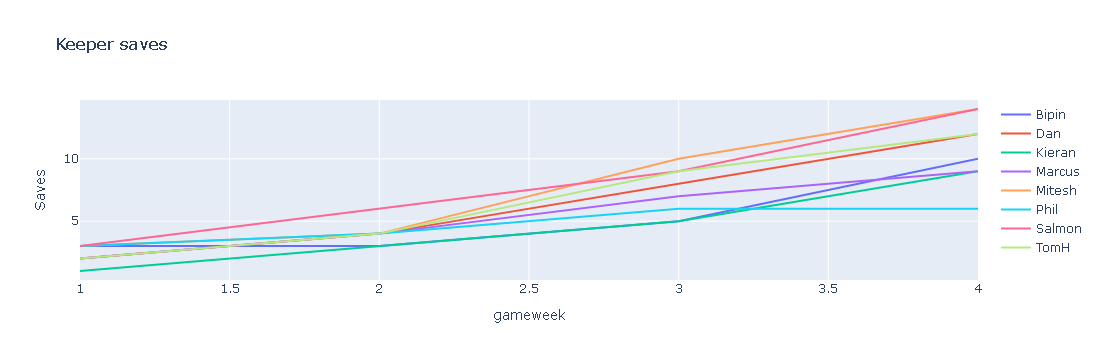

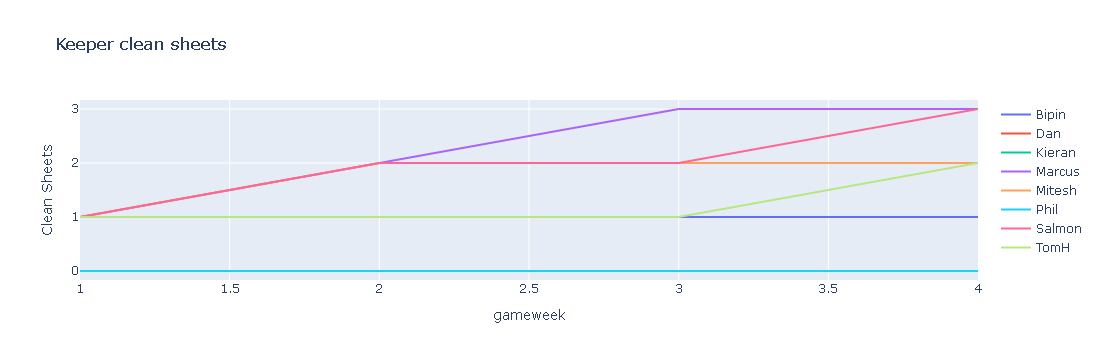

In [37]:
player_team_keeper_saves = merged_perfomance_data[merged_perfomance_data['position']==1].groupby(['gameweek','user_name'])['saves'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='saves').replace(np.nan,0)
fig = px.line(player_team_keeper_saves.cumsum(), title='Keeper saves',labels={'user_name':'','value':'Saves'})
fig.show()

player_team_keeper_clean_sheets = merged_perfomance_data[merged_perfomance_data['position']==1].groupby(['gameweek','user_name'])['clean_sheets'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='clean_sheets').replace(np.nan,0)
fig = px.line(player_team_keeper_clean_sheets.cumsum(), title='Keeper clean sheets',labels={'user_name':'','value':'Clean Sheets'})
fig.show()

### Defender performance

In [38]:
player_team_defender_performance_difference = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='DEF')].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').replace(np.nan,0)
player_team_defender_performance_difference.rank(1,ascending=False).astype(int).T.style.background_gradient(cmap='RdBu').set_properties(**{'width':'2em','text-align': 'center'})

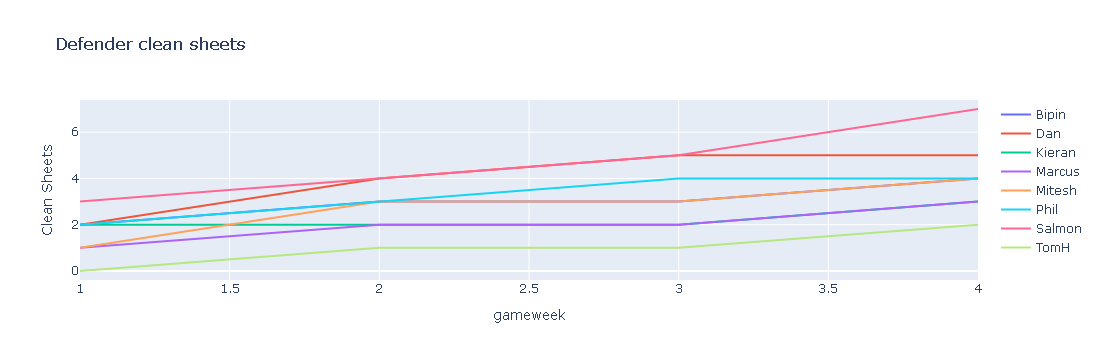

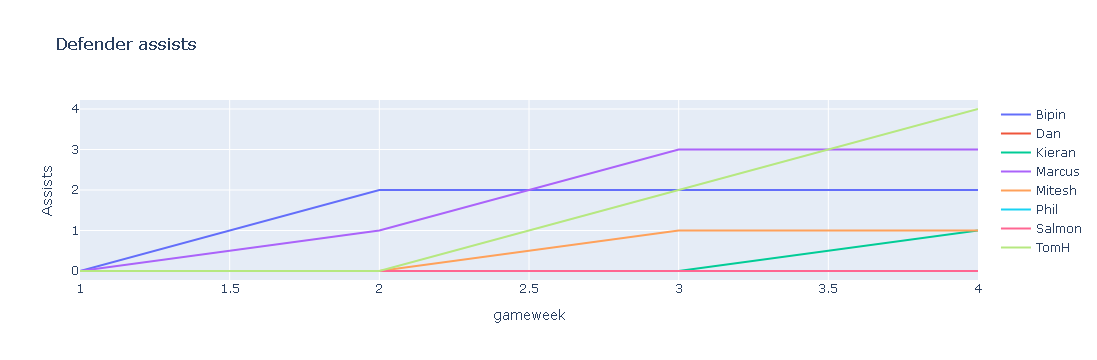

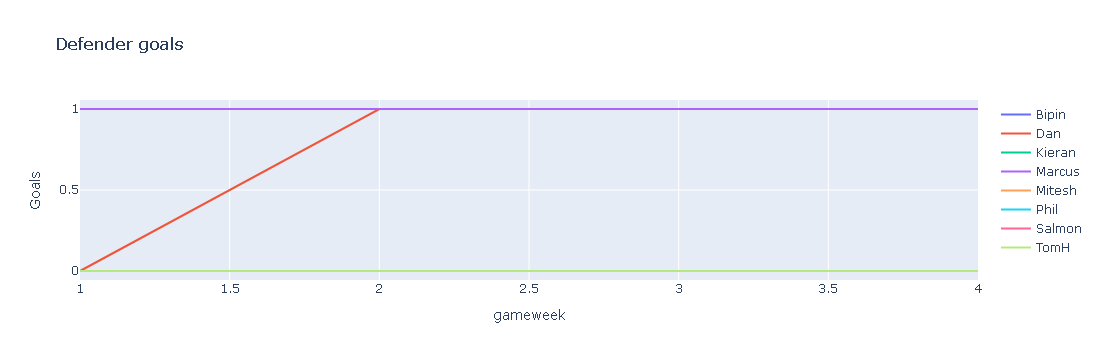

In [39]:
player_team_defender_clean_sheets = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='DEF')].groupby(['gameweek','user_name'])['clean_sheets'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='clean_sheets').replace(np.nan,0)
fig = px.line(player_team_defender_clean_sheets.cumsum(), title='Defender clean sheets',labels={'user_name':'','value':'Clean Sheets'})
fig.show()

player_team_defender_assists = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='DEF')].groupby(['gameweek','user_name'])['assists'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='assists').replace(np.nan,0)
fig = px.line(player_team_defender_assists.cumsum(), title='Defender assists',labels={'user_name':'','value':'Assists'})
fig.show()

player_team_defender_goals = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='DEF')].groupby(['gameweek','user_name'])['goals_scored'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='goals_scored').replace(np.nan,0)
fig = px.line(player_team_defender_goals.cumsum(), title='Defender goals',labels={'user_name':'','value':'Goals'})
fig.show()

### Midfielder performance

In [40]:
player_team_midfielder_performance_difference = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='MID')].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').replace(np.nan,0)
player_team_midfielder_performance_difference.rank(1,ascending=False).astype(int).T.style.background_gradient(cmap='RdBu').set_properties(**{'width':'2em','text-align': 'center'})

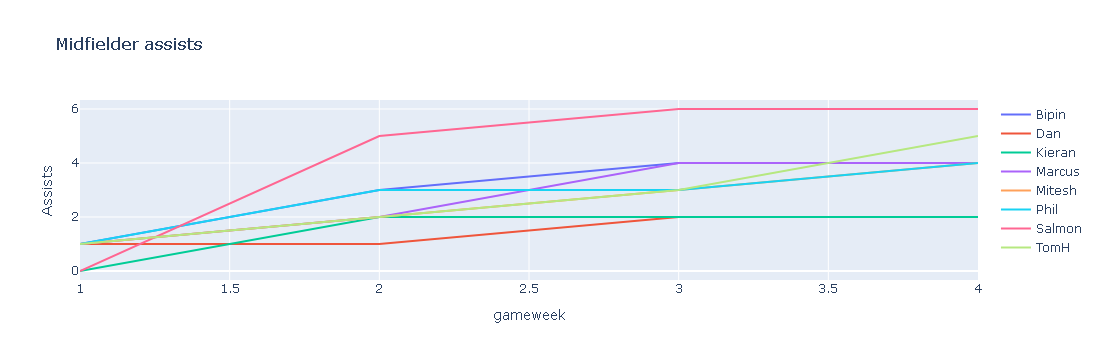

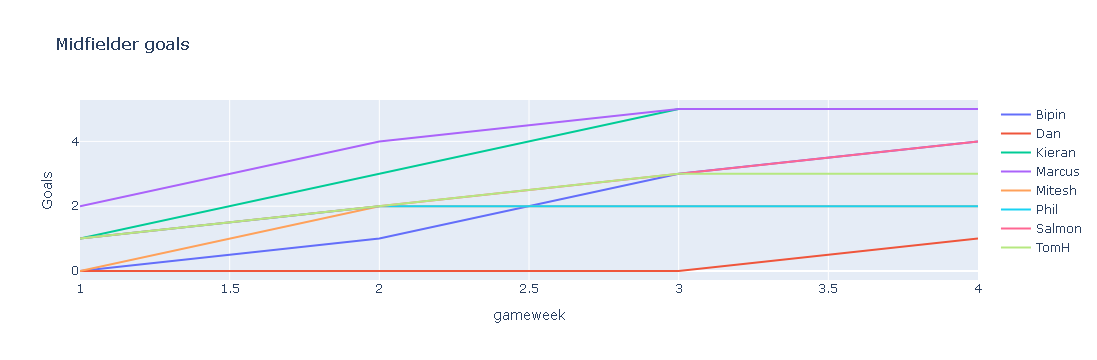

In [41]:
player_team_midfielder_assists = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='MID')].groupby(['gameweek','user_name'])['assists'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='assists').replace(np.nan,0)
fig = px.line(player_team_midfielder_assists.cumsum(), title='Midfielder assists',labels={'user_name':'','value':'Assists'})
fig.show()

player_team_midfielder_goals = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='MID')].groupby(['gameweek','user_name'])['goals_scored'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='goals_scored').replace(np.nan,0)
fig = px.line(player_team_midfielder_goals.cumsum(), title='Midfielder goals',labels={'user_name':'','value':'Goals'})
fig.show()

### Forward performance

In [42]:
player_team_forward_performance_difference = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='FWD')].groupby(['gameweek','user_name'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='total_points').replace(np.nan,0)
player_team_forward_performance_difference.rank(1,ascending=False).astype(int).T.style.background_gradient(cmap='RdBu').set_properties(**{'width':'2em','text-align': 'center'})

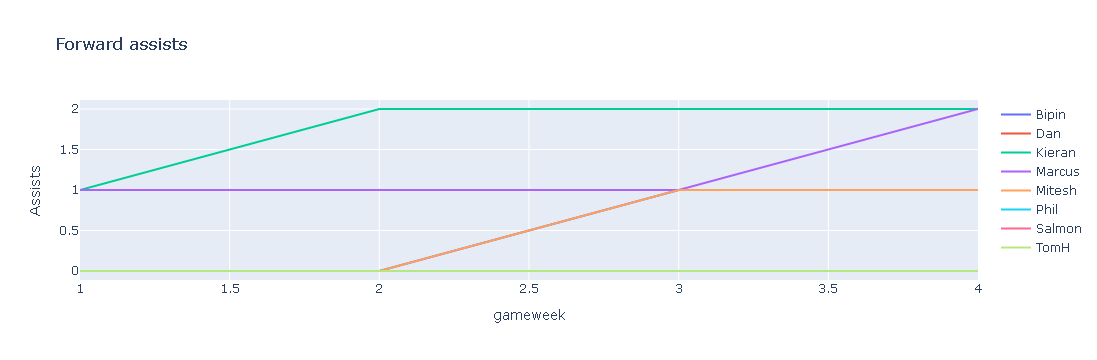

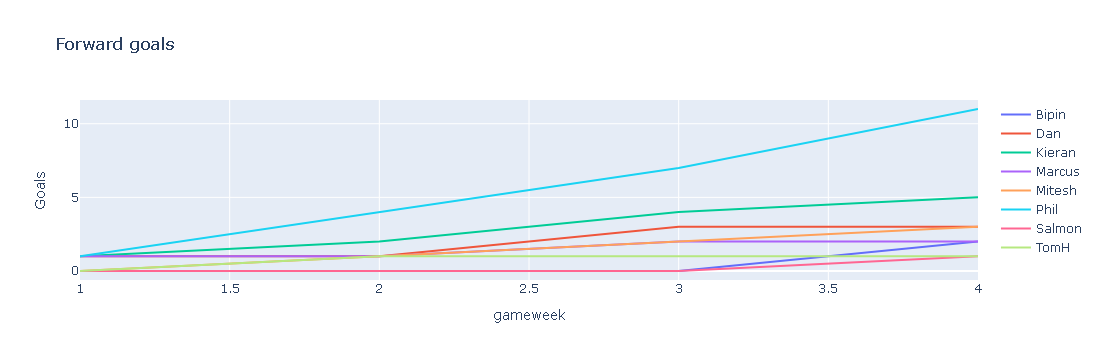

In [43]:
player_team_forward_assists = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='FWD')].groupby(['gameweek','user_name'])['assists'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='assists').replace(np.nan,0)
fig = px.line(player_team_forward_assists.cumsum(), title='Forward assists',labels={'user_name':'','value':'Assists'})
fig.show()

player_team_forward_goals = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) & (merged_perfomance_data['player_position']=='FWD')].groupby(['gameweek','user_name'])['goals_scored'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='goals_scored').replace(np.nan,0)
fig = px.line(player_team_forward_goals.cumsum(), title='Forward goals',labels={'user_name':'','value':'Goals'})
fig.show()

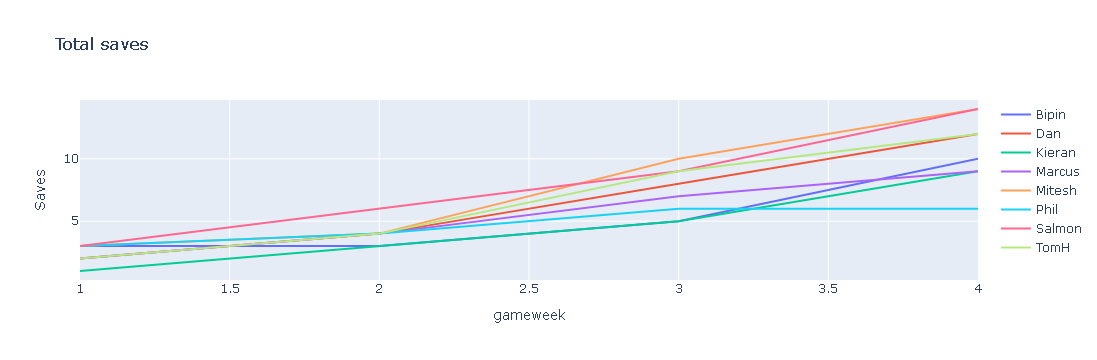

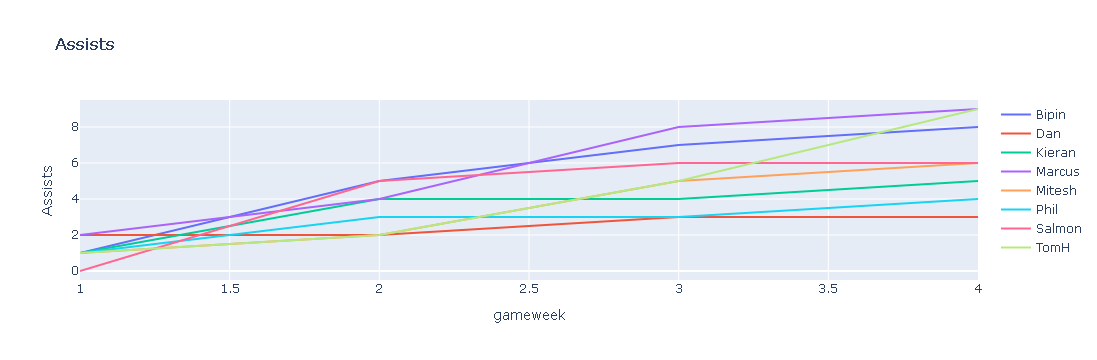

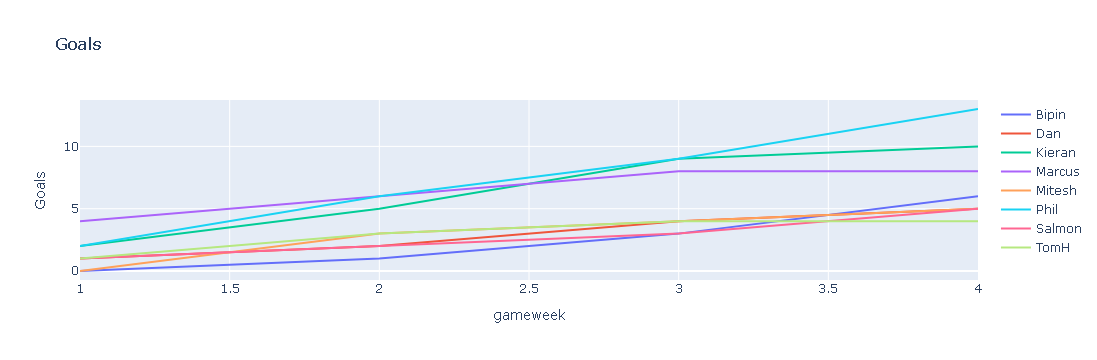

In [44]:
total_saves_by_user = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing))].groupby(['gameweek','user_name'])['saves'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='saves').replace(np.nan,0)
total_clean_sheets_by_user = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing))].groupby(['gameweek','user_name'])['clean_sheets'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='clean_sheets').replace(np.nan,0)
total_assists_by_user = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing))].groupby(['gameweek','user_name'])['assists'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='assists').replace(np.nan,0)
total_goals_by_user = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing))].groupby(['gameweek','user_name'])['goals_scored'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='goals_scored').replace(np.nan,0)
total_bps_by_user = merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing))].groupby(['gameweek','user_name'])['bonus'].sum().reset_index().pivot(index='gameweek',columns='user_name',values='bonus').replace(np.nan,0)

fig = px.line(total_saves_by_user.cumsum(), title='Total saves',labels={'user_name':'','value':'Saves'})
fig.show()

fig = px.line(total_clean_sheets_by_user.cumsum(), title='Clean sheets',labels={'user_name':'','value':'Clean Sheets'})
fig.show()

fig = px.line(total_assists_by_user.cumsum(), title='Assists',labels={'user_name':'','value':'Assists'})
fig.show()

fig = px.line(total_goals_by_user.cumsum(), title='Goals',labels={'user_name':'','value':'Goals'})
fig.show()

fig = px.line(total_bps_by_user.cumsum(), title='Bonus points',labels={'user_name':'','value':'Bonus Points'})
fig.show()

In [45]:
fig = px.bar(user_player_ownership.nunique(0).sort_values(ascending=False)[:10],title='Most traded players', labels={'value':'Number of ownes','player_name':''})
fig.layout.update(showlegend=False)
fig.show()

### Top 50 player points per game

In [46]:
# Percentage of points received for new players in teams
user_player_percentage_points = pd.merge(merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing))].groupby(['user_name', 'player_name'])['total_points'].sum().reset_index().rename(columns={'total_points':'player_points'}), 
                                         merged_perfomance_data.groupby(['player_name'])['total_points'].sum().replace(np.nan, 0).reset_index(),
                                         on=['player_name'],
                                         how='left')
user_player_percentage_points = pd.merge(user_player_percentage_points,
                                         merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing))].groupby(['user_name', 'player_name'])['total_points'].count().reset_index().rename(columns={'total_points':'player_games'}),
                                         on=['user_name','player_name'],
                                         how='left')
user_player_percentage_points['player_percentage_points'] = 100. * user_player_percentage_points['player_points'] / user_player_percentage_points['total_points'].replace(0, np.nan)
user_player_percentage_points['player_points_per_game'] = user_player_percentage_points['player_points'] / user_player_percentage_points['player_games'].replace(0, np.nan)
# user_player_percentage_points.sort_values('player_percentage_points', ascending=False).style.hide_index()
user_player_percentage_points.sort_values('player_points_per_game', ascending=False)[:50].style.hide_index()

AttributeError: 'Styler' object has no attribute 'hide_index'

In [47]:
player_transfers = pd.merge(user_player_ownership.unstack().reset_index().rename(columns={0:'owner'}),user_player_ownership.shift(1).unstack().reset_index().rename(columns={0:'previous_owner'}),on=['player_name','gameweek'])
player_transfers = player_transfers[(player_transfers['owner']!=player_transfers['previous_owner']) & (player_transfers['gameweek']>1)]
player_transfers = player_transfers.sort_values(['gameweek','owner','player_name']).reset_index(drop=True)
player_transfers['gameweek'] = player_transfers['gameweek'].astype(int)

player_transfers = pd.merge(player_transfers,player_team_performance.cumsum().rank(1,ascending=False).astype(int).unstack().reset_index().rename(columns={0:'owner_position','user_name':'owner'}),on=['gameweek','owner'],how='left')
player_transfers = pd.merge(player_transfers,player_team_performance.cumsum().rank(1,ascending=False).astype(int).unstack().reset_index().rename(columns={0:'previous_owner_position','user_name':'previous_owner'}),on=['gameweek','previous_owner'],how='left')

player_transfers['Points after transfer'] = [merged_perfomance_data[(merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['gameweek']>=player_transfers.at[i,'gameweek'])]['total_points'].sum() for i in player_transfers.index]
player_transfers['Games after transfer'] = [merged_perfomance_data[(merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['gameweek']>=player_transfers.at[i,'gameweek'])]['total_points'].count() for i in player_transfers.index]
player_transfers['Points per game after transfer'] = player_transfers['Points after transfer'] / player_transfers['Games after transfer']

player_transfers['Points before transfer'] = [merged_perfomance_data[(merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['gameweek']<player_transfers.at[i,'gameweek'])]['total_points'].sum() for i in player_transfers.index]
player_transfers['Games before transfer'] = [merged_perfomance_data[(merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['gameweek']<player_transfers.at[i,'gameweek'])]['total_points'].count() for i in player_transfers.index]
player_transfers['Points per game before transfer'] = player_transfers['Points before transfer'] / player_transfers['Games before transfer']

player_transfers['Points after transfer for owner'] = [merged_perfomance_data[(merged_perfomance_data['user_name']==player_transfers.at[i,'owner']) & (merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['gameweek']>=player_transfers.at[i,'gameweek'])]['total_points'].sum() for i in player_transfers.index]
player_transfers['Games after transfer for owner'] = [merged_perfomance_data[(merged_perfomance_data['user_name']==player_transfers.at[i,'owner']) & (merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['gameweek']>=player_transfers.at[i,'gameweek'])]['total_points'].count() for i in player_transfers.index]
player_transfers['Points per game after transfer for owner'] = player_transfers['Points after transfer for owner'] / player_transfers['Games after transfer for owner']

player_transfers['Points before transfer for previous owner'] = [merged_perfomance_data[(merged_perfomance_data['user_name']==player_transfers.at[i,'previous_owner']) & (merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['gameweek']<player_transfers.at[i,'gameweek'])]['total_points'].sum() for i in player_transfers.index]
player_transfers['Games before transfer for previous owner'] = [merged_perfomance_data[(merged_perfomance_data['user_name']==player_transfers.at[i,'previous_owner']) & (merged_perfomance_data['player_name']==player_transfers.at[i,'player_name']) & (merged_perfomance_data['gameweek']<player_transfers.at[i,'gameweek'])]['total_points'].count() for i in player_transfers.index]
player_transfers['Points per game before transfer for previous owner'] = player_transfers['Points before transfer for previous owner'] / player_transfers['Games before transfer for previous owner']

user_to_user_player_transfers = player_transfers[(player_transfers['owner']!='No_owner') & (player_transfers['previous_owner']!='No_owner')].reset_index(drop=True)

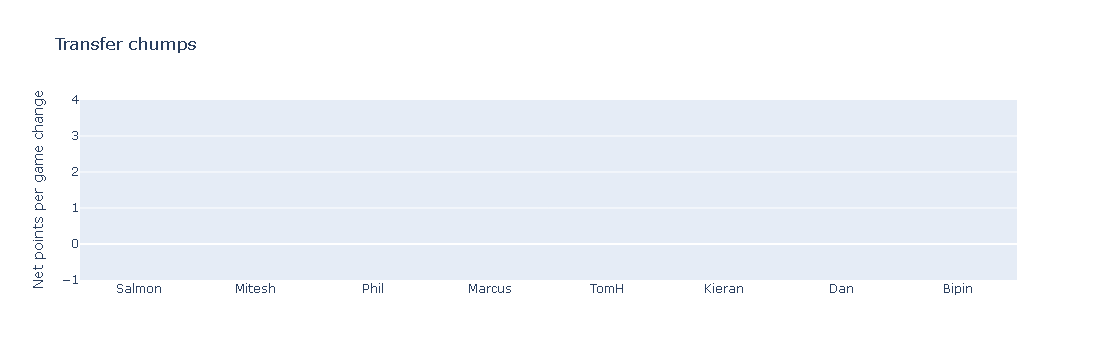

In [48]:
transfer_chumps = pd.Series([user_to_user_player_transfers[user_to_user_player_transfers['owner']==user_name]['Points per game after transfer for owner'].mean()-user_to_user_player_transfers[user_to_user_player_transfers['owner']==user_name]['Points per game before transfer for previous owner'].mean() for user_name in user_names],index=user_names)
fig = px.bar(transfer_chumps.sort_values(),title='Transfer chumps', labels={'value':'Net points per game change','index':''})
fig.layout.update(showlegend=False)
fig.show()

In [49]:
def format_color_groups(df, column='gameweek'):
    colors = ['#e8e8e8', '#d6d6cb']
    x = df.copy()
    factors = list(x[column].unique())
    i = 0
    for factor in factors:
        style = f'background-color: {colors[i]}'
        x.loc[x[column] == factor, :] = style
        i = not i
    return x

### Worst trades

In [50]:
player_transfers_worst = []
for gameweek in gameweeks[1:]:
    player_transfers_performance = player_transfers[player_transfers['gameweek']==gameweek].sort_values('Points per game after transfer for owner').reset_index(drop=True)[['gameweek','owner','owner_position','previous_owner','previous_owner_position','player_name','Points per game after transfer for owner','Points per game before transfer for previous owner']]
    player_transfers_worst.append(player_transfers_performance[player_transfers_performance['Points per game after transfer for owner']==player_transfers_performance.iloc[0]['Points per game after transfer for owner']])
player_transfers_worst = pd.concat(player_transfers_worst).reset_index(drop=True)
player_transfers_worst['owner'] = ['{} ({})'.format(player_transfers_worst.at[i,'owner'],player_transfers_worst.at[i,'owner_position']) for i in player_transfers_worst.index]
player_transfers_worst['previous_owner'] = ['{} ({})'.format(player_transfers_worst.at[i,'previous_owner'],player_transfers_worst.at[i,'previous_owner_position']) for i in player_transfers_worst.index]

player_transfers_worst = player_transfers_worst[['gameweek','owner','previous_owner','player_name','Points per game after transfer for owner','Points per game before transfer for previous owner']]
player_transfers_worst.style.apply(format_color_groups,axis=None).hide_index()

# freeze_header(df=player_transfers_worst)

AttributeError: 'Styler' object has no attribute 'hide_index'

### Best trades

In [51]:
player_transfers_best = []
for gameweek in gameweeks[1:]:
    player_transfers_performance = player_transfers[player_transfers['gameweek']==gameweek].sort_values('Points per game after transfer for owner',ascending=False).reset_index(drop=True)[['gameweek','owner','owner_position','previous_owner','previous_owner_position','player_name','Points per game after transfer for owner','Points per game before transfer for previous owner']]
    player_transfers_best.append(player_transfers_performance[player_transfers_performance['Points per game after transfer for owner']==player_transfers_performance.iloc[0]['Points per game after transfer for owner']])
player_transfers_best = pd.concat(player_transfers_best).reset_index(drop=True)
player_transfers_best['owner'] = ['{} ({})'.format(player_transfers_best.at[i,'owner'],player_transfers_best.at[i,'owner_position']) for i in player_transfers_best.index]
player_transfers_best['previous_owner'] = ['{} ({})'.format(player_transfers_best.at[i,'previous_owner'],player_transfers_best.at[i,'previous_owner_position']) for i in player_transfers_best.index]

player_transfers_best = player_transfers_best[['gameweek','owner','previous_owner','player_name','Points per game after transfer for owner','Points per game before transfer for previous owner']]
player_transfers_best.style.apply(format_color_groups,axis=None).format({'Points per game after transfer for owner':"{:.2f}",'Points per game before transfer for previous owner':"{:.2f}"}).hide_index()

AttributeError: 'Styler' object has no attribute 'hide_index'

### User to user trades

In [52]:
user_to_user_transfers_all = user_to_user_player_transfers[['gameweek','owner','owner_position','previous_owner','previous_owner_position','player_name','Points per game after transfer for owner','Points per game before transfer for previous owner']]
user_to_user_transfers_all['owner'] = ['{} ({})'.format(user_to_user_transfers_all.at[i,'owner'],user_to_user_transfers_all.at[i,'owner_position']) for i in user_to_user_transfers_all.index]
user_to_user_transfers_all['previous_owner'] = ['{} ({})'.format(user_to_user_transfers_all.at[i,'previous_owner'],user_to_user_transfers_all.at[i,'previous_owner_position']) for i in user_to_user_transfers_all.index]

user_to_user_transfers_all = user_to_user_transfers_all[['gameweek','owner','previous_owner','player_name','Points per game after transfer for owner','Points per game before transfer for previous owner']]
user_to_user_transfers_all.sort_values(['gameweek','owner','previous_owner']).style.apply(format_color_groups,axis=None).format({'Points per game after transfer for owner':"{:.2f}",'Points per game before transfer for previous owner':"{:.2f}"}).hide_index()

AttributeError: 'Styler' object has no attribute 'hide_index'

In [53]:
user_to_user_transfers_all['owners'] = user_to_user_transfers_all['owner'] + '_' + user_to_user_transfers_all['previous_owner']
user_to_user_transfers_all['owners'] = user_to_user_transfers_all['owners'].mask(user_to_user_transfers_all['owner']>user_to_user_transfers_all['previous_owner'],user_to_user_transfers_all['previous_owner'] + '_' + user_to_user_transfers_all['owner'])

user_to_user_transfers_all['net_points_per_game'] = user_to_user_transfers_all['Points per game after transfer for owner'] - user_to_user_transfers_all['Points per game before transfer for previous owner']
user_to_user_transfers_all['net_points_per_game'] = user_to_user_transfers_all['net_points_per_game'].mask(user_to_user_transfers_all['owner']>user_to_user_transfers_all['previous_owner'],user_to_user_transfers_all['Points per game before transfer for previous owner'] - user_to_user_transfers_all['Points per game after transfer for owner'])

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U1')) -> None

In [ ]:
user_to_user_transfers_all.groupby(['gameweek','owners'])['net_points_per_game'].sum().reset_index().sort_values(['gameweek','owners']).style.apply(format_color_groups,axis=None).format({'net_points_per_game':"{:.2f}"}).hide_index()

In [ ]:
fig = px.line(player_transfers.groupby('gameweek')['player_name'].count()/2., title='Total league transfers')
fig.layout.update(showlegend=False)
fig.show()
#
fig = px.line(user_to_user_player_transfers.groupby('gameweek')['player_name'].count()/2., title='Total user-to-user transfers')
fig.layout.update(showlegend=False)
fig.show()

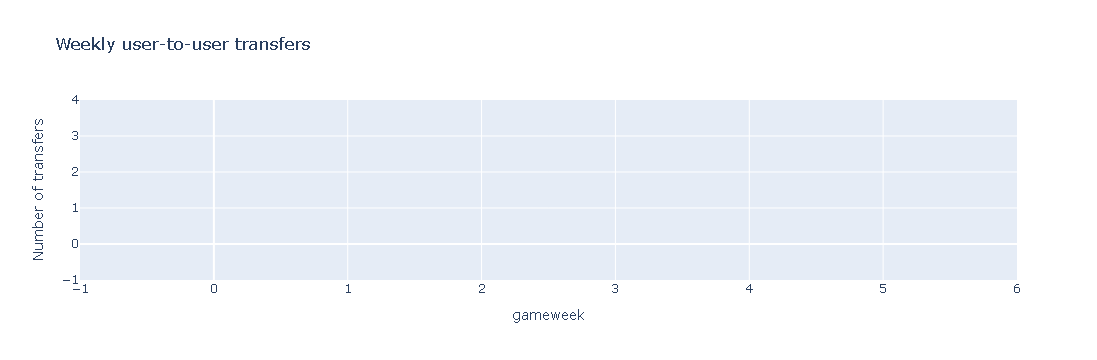

In [54]:
fig = px.line(user_to_user_player_transfers.groupby(['gameweek','owner'])['player_name'].count().reset_index().pivot(index='gameweek',columns='owner',values='player_name').fillna(0), title='Weekly user-to-user transfers', labels={'owner':'','value':'Number of transfers'})
fig.show()

In [55]:
user_player_gameweeks = merged_perfomance_data[merged_perfomance_data['user_id'].notnull()][['user_id', 'player_name', 'gameweek', 'total_points']].drop_duplicates()
user_player_gameweeks['previous_gameweek'] = user_player_gameweeks['gameweek'].subtract(1)
user_player_gameweeks['next_gameweek'] = user_player_gameweeks['gameweek'].add(1)

user_player_gameweeks = pd.merge(user_player_gameweeks,
                                 user_player_gameweeks[['user_id', 'player_name', 'gameweek', 'total_points']].rename(columns={'gameweek': 'previous_gameweek',
                                                                                                                               'total_points': 'previous_points'}),
                                 how='left',
                                 on=['user_id', 'player_name', 'previous_gameweek'])

user_player_gameweeks = pd.merge(user_player_gameweeks,
                                 user_player_gameweeks[['user_id', 'player_name', 'gameweek', 'total_points']].rename(columns={'gameweek': 'next_gameweek',
                                                                                                                               'total_points': 'next_points'}),
                                 how='left',
                                 on=['user_id', 'player_name', 'next_gameweek'])

### First picks performance

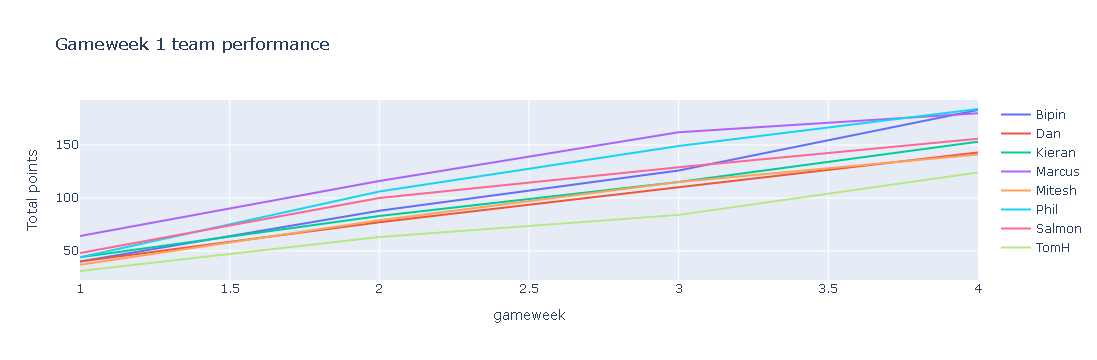

In [56]:
gameweek1_teams = merged_perfomance_data[merged_perfomance_data['gameweek']==1]
gameweek1_teams = gameweek1_teams[gameweek1_teams['position'].isin(positions_playing)][['player_name','user_name']].rename(columns={'user_name':'gameweek1_user'})

gameweek1_performace = pd.merge(merged_perfomance_data,gameweek1_teams,on=['player_name'])
gameweek1_performace = gameweek1_performace[gameweek1_performace['gameweek1_user'].isin(user_names)].groupby(['gameweek1_user','gameweek'])['total_points'].sum().reset_index().pivot(index='gameweek',columns='gameweek1_user',values='total_points')

fig = px.line(gameweek1_performace.cumsum(), title='Gameweek 1 team performance', labels={'gameweek1_user':'','value':'Total points'})
fig.show()

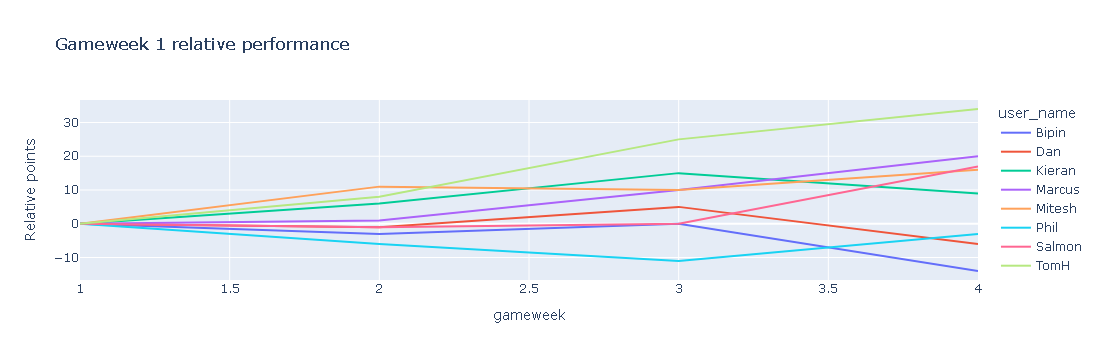

In [57]:
relative_gameweek1performanace = player_team_performance - gameweek1_performace
fig = px.line(relative_gameweek1performanace.cumsum(), title='Gameweek 1 relative performance', labels={'gameweek1_user':'','value':'Relative points'})
fig.show()

# The Sol Campbell Award

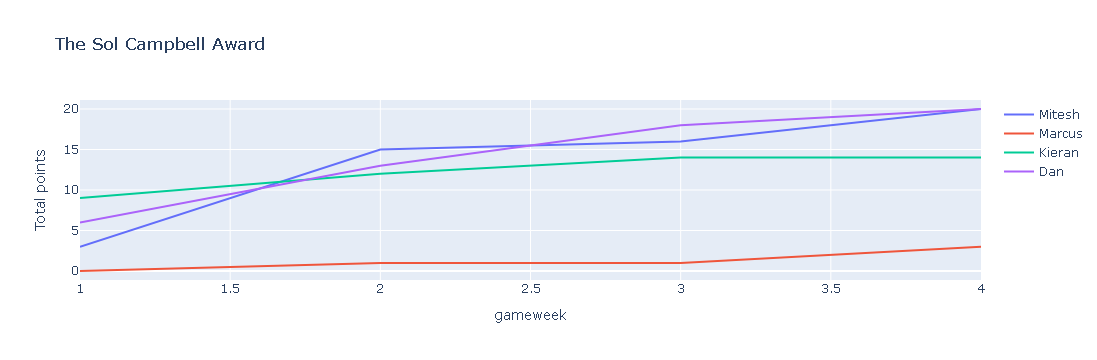

In [58]:
traitor_teams = {
    'Mitesh':'MCI',
    'Marcus':'MUN',
    'Kieran':'ARS',
    'Dan':'LIV',
    'Salmon':'TOT',
    'Bipin':'FUL',
    'Phil':'None',
    'TomH':'LIV'
}

sol_campbell_performance = {}

for user_name in user_names:
    sol_campbell_performance_temp = (merged_perfomance_data[(merged_perfomance_data['position'].isin(positions_playing)) 
                                                            & (merged_perfomance_data['user_name'] == user_name)
                                                            & (merged_perfomance_data['player_team'] == traitor_teams.get(user_name))])
                                           
    if len(sol_campbell_performance_temp) > 0:
        sol_campbell_performance[user_name] = sol_campbell_performance_temp.groupby(['gameweek'])['total_points'].sum()

sol_campbell_performance = pd.DataFrame(sol_campbell_performance)

fig = px.line(sol_campbell_performance.replace(np.nan, 0).cumsum().fillna(method='ffill'), title='The Sol Campbell Award', labels={'variable':'','value':'Total points'})
fig.show()

# Side bets

<!-- <H2> Marcus vs. Mitesh (Hojlund vs. Solanke) -->

In [59]:
# solanke_points = merged_perfomance_data[merged_perfomance_data['player_name'].str.contains('Solanke')]['total_points'].sum()
# hojlund_points = merged_perfomance_data[merged_perfomance_data['player_name'].str.contains('Højlund')]['total_points'].sum()
# print(f"Solanke: {solanke_points} points") 
# print(f"Hojlund: {hojlund_points} points") 

# Cup Competition

In [60]:
# cup_draw = {
#         1:{
#             'Salmon': 'TomH',
#             'Conlon': 'Marcus',
#             'Kieran': 'Mitesh',
#             'Bipin': 'Verity',            
#         },
#         2:{
#             'Marcus':'Verity',
#             'Salmon':'Mitesh',
#         },
#         3:{
#             'Marcus':'Mitesh',
#         }    
# }

## Round of 10

In [61]:
def cup_output(qf_index, cup_week, preview=False):
    if preview:
        cup_week = cup_week - 1
    
    cup_draw_qf = cup_draw[qf_index]
    merged_perfomance_data_selected = merged_perfomance_data[merged_perfomance_data['gameweek'] <= cup_week]
    player_history_selected = player_history[player_history['gameweek'] <= cup_week]
    player_team_performance_selected = player_team_performance[player_team_performance.index <= cup_week]
    player_performance_per_game = pd.DataFrame(player_history_selected.groupby('element')['total_points'].sum() / player_history_selected[player_history_selected['minutes']>0].groupby('element')['total_points'].count()).rename(columns={'total_points':'player_points_per_game'})

    qf_user_list = np.concatenate([[k, v] for k, v in cup_draw_qf.items()])
    qf_comparison_dict = {}
    for i in list(cup_draw_qf.keys()):
        user1 = i
        user2 = cup_draw_qf[i]

        metric_list = ['Total points','Mean points','Stdev points','Max score','Min score','Total goals','Total assists',
                       'Total clean sheets','Total saves','Current squad av. ppg','Best current player (ppg)']

        qf_comparison = pd.DataFrame(index=metric_list,columns=[user1,user2])
        recent_h2h = player_team_performance_selected[[user1, user2]].tail(10)

        recent_h2h_wl = pd.DataFrame(index=recent_h2h.index, columns=recent_h2h.columns)
        recent_h2h_wl[user1] = (recent_h2h[user1] > recent_h2h[user2]).replace(True, 'W ').replace(False, 'L ')
        recent_h2h_wl[user2] = (recent_h2h[user2] > recent_h2h[user1]).replace(True, 'W ').replace(False, 'L ')
        recent_h2h_wl.loc[recent_h2h_wl[user1]==recent_h2h_wl[user2], [user1, user2]] = ['D', 'D']
    #     recent_h2h_wl.loc[recent_h2h_wl[user1]==recent_h2h_wl[user2], user2] = 'D'

        for user in qf_comparison.columns:
            qf_comparison.at['Total points',user] = player_team_performance_selected[user].sum()
            qf_comparison.at['Mean points',user] = round(player_team_performance_selected[user].mean(),1)
            qf_comparison.at['Stdev points',user] = round(player_team_performance_selected[user].std(),1)
            qf_comparison.at['Min score',user] = player_team_performance_selected[user].min()
            qf_comparison.at['Max score',user] = player_team_performance_selected[user].max()
            qf_comparison.at['Total saves',user] = total_saves_by_user[user].sum()
            qf_comparison.at['Total clean sheets',user] = total_clean_sheets_by_user[user].sum()
            qf_comparison.at['Total assists',user] = total_assists_by_user[user].sum()
            qf_comparison.at['Total goals',user] = total_goals_by_user[user].sum()
            qf_comparison.at['Recent Head to Head', user] = ''.join(recent_h2h_wl[user].values)

    #         current_players_points_per_game = pd.merge(merged_perfomance_data_selected[(merged_perfomance_data_selected['position'].isin(positions_playing)) & (merged_perfomance_data_selected['user_name']==user) & (merged_perfomance_data_selected['gameweek']==max_gameweek)],player_performance_per_game,how='left',on='element').sort_values('player_points_per_game',ascending=False)
            current_players_points_per_game = pd.merge(merged_perfomance_data_selected[(merged_perfomance_data_selected['user_name']==user) & (merged_perfomance_data_selected['gameweek']==cup_week)],player_performance_per_game,how='left',on='element').sort_values('player_points_per_game',ascending=False).reset_index(drop=True)
            current_players_points_per_game = current_players_points_per_game.loc[current_players_points_per_game[['user_name', 'gameweek', 'position']]
                                                                                  .sort_index()
                                                                                  .drop_duplicates(keep='last').index]
    #         current_players_points_per_game_dict[user] = current_players_points_per_game[current_player_columns]
            qf_comparison.at['Best current player (ppg)',user] = "{} ({:.2f})".format(current_players_points_per_game['player_name'].iloc[0],current_players_points_per_game['player_points_per_game'].iloc[0])
            qf_comparison.at['Current squad av. ppg',user] = "{:.2f}".format(current_players_points_per_game['player_points_per_game'].mean())

        qf_comparison_dict[user1+'_'+user2] = qf_comparison
    
    current_players_points_per_game_dict = {}
    current_player_columns = ['user_name','position','player_name','player_position','player_points_per_game']

    if max_gameweek == cup_week:
        for user in qf_user_list:
            current_players_points_per_game_dict[user] = pd.merge(merged_perfomance_data_selected[(merged_perfomance_data_selected['user_name']==user) & (merged_perfomance_data_selected['gameweek']==cup_week)],player_performance_per_game,how='left',on='element').sort_values('player_points_per_game',ascending=False)[current_player_columns]
            display(current_players_points_per_game_dict[user].drop_duplicates(keep='last'))

        for i in list(qf_comparison_dict.keys()):
            display(qf_comparison_dict[i])
        
    cup_points = merged_perfomance_data_selected[(merged_perfomance_data_selected['gameweek']==cup_week)
                       & (merged_perfomance_data_selected['position'] < 12)].groupby('user_name')['total_points'].sum()
    for i in cup_draw_qf.items():
        print("{} ({}) vs. {} ({})".format(i[0], cup_points[i[0]], i[1], cup_points[i[1]]))

In [62]:
# cup_output(qf_index=1, cup_week=30)

## Quarter-finals

In [63]:
# cup_output(qf_index=1, cup_week=31)

## Semi-finals

In [64]:
# cup_output(qf_index=2, cup_week=33)

## Final

In [65]:
# cup_output(qf_index=3, cup_week=35)